# TCD Tracing Example Implementation

This notebook demonstrates how to use the Python modules for Transcranial Doppler (TCD) envelope tracing. We will walk through loading data, generating a spectrogram, and running the tracing algorithms.

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import PchipInterpolator

# Add the current directory to sys.path if necessary, so we can import local modules
import sys
if '.' not in sys.path:
    sys.path.append('.')

# Import our custom modules
from preprocessing import preprocess_time_vector, segment_echo_signal, load_tcd_data, segment_cbfv_into_windows
from spectrogram_utils import generate_spectrogram
from tracing import spectrogram_tracing, ultrasound_tracing_mtcm
from postprocessing import postprocess_cbfv

## 1. Load Data

We will load a sample recording. If the file doesn't exist, we'll generate some dummy data for demonstration.

In [28]:
# Configuration
# filepath = '../Healthy Subjects/' 
filepath = '.' 
filename = 'Healthy_Subjects_Recording_8.txt'
full_path = os.path.join(filepath, filename)

# Try standard locations
if not os.path.exists(full_path):
    # Check relative to notebook location if running inside TCD tracing code/Code PY
    potential_paths = [
        os.path.join('../../Healthy Subjects', filename),
        filename
    ]
    for p in potential_paths:
        if os.path.exists(p):
            full_path = p
            break

if os.path.exists(full_path):
    print(f"Loading data from {full_path}...")
    raw_echo_data = load_tcd_data(full_path)
else:
    print("File not found. Generating dummy data...")
    t_dummy = np.arange(0, 5, 1/5000.0) # 5 seconds
    # Simulate a Doppler signal with varying frequency (pulsatile flow)
    freq_profile = 1000 + 500 * np.sin(2 * np.pi * 1 * t_dummy) # 1 Hz beat
    phase = 2 * np.pi * np.cumsum(freq_profile) / 5000.0
    carrier = np.exp(1j * phase)
    noise = (np.random.randn(len(t_dummy)) + 1j * np.random.randn(len(t_dummy))) * 0.1
    iq_signal = carrier + noise
    
    raw_echo_data = pd.DataFrame({
        't': t_dummy * 1e6,
        'I': np.real(iq_signal),
        'Q': np.imag(iq_signal)
    })

# Display first few rows
raw_echo_data.head()

Loading data from .\Healthy_Subjects_Recording_8.txt...


,t,I,Q
0,1526693525,-449,1372
1,1526695594,1395630,-193177
2,1526695742,1318217,-179209
3,1526695886,1364590,-179709
4,1526696030,1381759,-177301


In [29]:
raw_echo_data.shape

(3803966, 3)

In [30]:
raw_echo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3803966 entries, 0 to 3803965
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   t       int64
 1   I       int64
 2   Q       int64
dtypes: int64(3)
memory usage: 87.1 MB


In [31]:
raw_echo_data.isnull().sum()

t    0
I    0
Q    0
dtype: int64

In [32]:
raw_echo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3803966 entries, 0 to 3803965
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   t       int64
 1   I       int64
 2   Q       int64
dtypes: int64(3)
memory usage: 87.1 MB


## 2. Preprocessing

We process the time vector to handle any overflows and segment the signal into manageable chunks.

In [4]:
# Preprocess time vector
t = preprocess_time_vector(raw_echo_data['t'].values)

# Segment echo data
tcd_echo_data = segment_echo_signal(raw_echo_data['I'].values, raw_echo_data['Q'].values, t)

print(f"Number of segments: {len(tcd_echo_data['t'])}")

Number of segments: 2


## 3. Process a Single Segment

We will take the first segment, generate its spectrogram, and run the envelope tracing algorithms.

In [5]:
# Parameters
fc = 1.75e6 # Transmit center frequency
ss = 1540   # Speed of sound
angle = 0   # Doppler angle
size_sp_filt = [3, 3]

# Select first segment
segment_idx = 0
iq_seg = tcd_echo_data['IQ'][segment_idx]
fs_seg = tcd_echo_data['fs'][segment_idx]
t_seg = tcd_echo_data['t'][segment_idx]

# 1. Generate Spectrogram
f_sp, t_sp, sp_seg, fs_sp = generate_spectrogram(iq_seg, fs_seg, t_seg)

# 2. Convert Frequency to Velocity (cm/s)
v_spectrogram = 100 * f_sp * ss / (2 * fc * np.cos(np.deg2rad(angle)))

# 3. Image Processing (Log compression & Filtering)
sp_log = np.log2(sp_seg + 1e-9)
sp_log = sp_log / np.max(sp_log)
sp_filt = signal.medfilt2d(sp_log, kernel_size=size_sp_filt)

# 4. Adaptive Envelope Tracing
# Calculate excluded indices for Otsu (if any)
ix_exclude_otsu = []
if len(tcd_echo_data['ix_low_freq'][segment_idx]) > 0:
    ratio = fs_sp / fs_seg
    ix_exclude_otsu = np.round(tcd_echo_data['ix_low_freq'][segment_idx] * ratio).astype(int)

cbfv_adaptive_raw, cbfv_sqi, img_bw, _ = spectrogram_tracing(v_spectrogram, sp_filt, fs_sp, ix_exclude_otsu)
cbfv_adaptive_smooth = postprocess_cbfv(cbfv_adaptive_raw, fs_sp)

# 5. MTCM Envelope Tracing
cbfv_mtcm = ultrasound_tracing_mtcm(v_spectrogram, sp_filt)
cbfv_mtcm_smooth = postprocess_cbfv(cbfv_mtcm, fs_sp)

## 4. Visualization (Segment Tracing)

Plot the spectrogram with the overlaid envelopes for the selected segment.

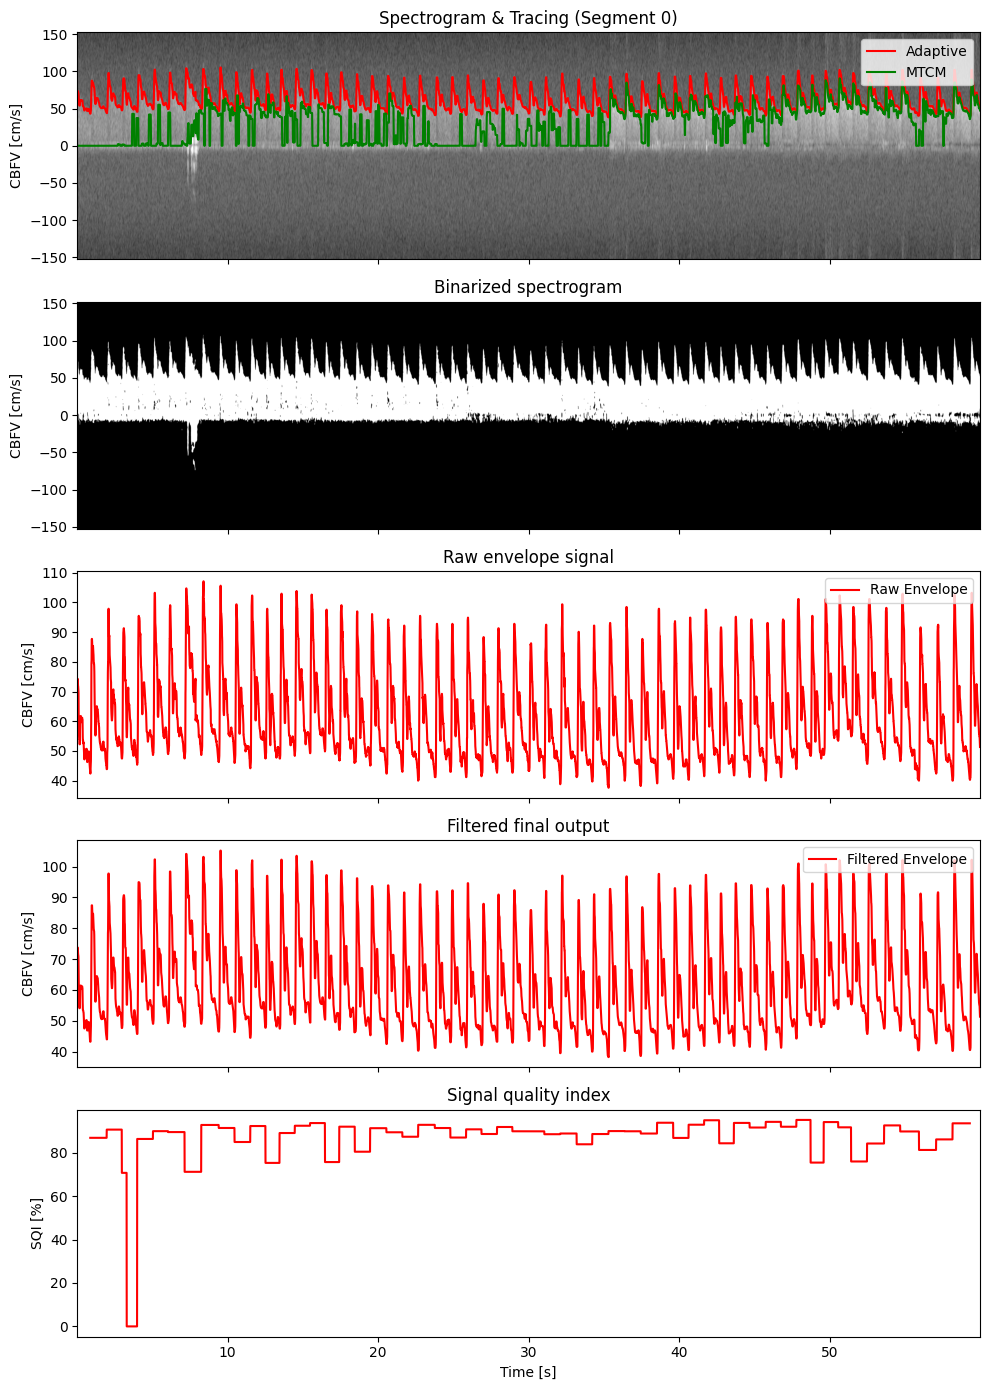

In [ ]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 14))

# Extent for imshow: [left, right, bottom, top]
extent = [t_sp[0], t_sp[-1], v_spectrogram[0], v_spectrogram[-1]]

# 1. Spectrogram with Traces
ax[0].imshow(sp_filt, aspect='auto', origin='lower', extent=extent, cmap='gray', vmin=0.1, vmax=0.95)
ax[0].plot(t_sp, cbfv_adaptive_smooth, 'r', linewidth=1.5, label='Adaptive')
ax[0].plot(t_sp, cbfv_mtcm_smooth, 'g', linewidth=1.5, label='MTCM')
ax[0].set_ylabel('CBFV [cm/s]')
ax[0].legend(loc='upper right')
ax[0].set_title(f'Spectrogram & Tracing (Segment {segment_idx})')

# 2. Binarized Spectrogram
ax[1].imshow(img_bw, aspect='auto', origin='lower', extent=extent, cmap='gray', vmin=0.0, vmax=1.0)
ax[1].set_ylabel('CBFV [cm/s]')
ax[1].set_title('Binarized spectrogram')

# 3. Raw Adaptive Envelope
ax[2].plot(t_sp, cbfv_adaptive_raw, 'r', linewidth=1.5, label='Raw Envelope')
ax[2].set_ylabel('CBFV [cm/s]')
ax[2].legend(loc='upper right')
ax[2].set_title('Raw envelope signal')

# 4. Filtered Adaptive Envelope
ax[3].plot(t_sp, cbfv_adaptive_smooth, 'r', linewidth=1.5, label='Filtered Envelope')
ax[3].set_ylabel('CBFV [cm/s]')
ax[3].legend(loc='upper right')
ax[3].set_title('Filtered final output')

# 5. SQI
ax[4].plot(t_sp, 100 * cbfv_sqi, 'r', linewidth=1.5)
ax[4].set_ylabel('SQI [%]')
ax[4].set_xlabel('Time [s]')
ax[4].set_title('Signal quality index')

plt.tight_layout()
plt.show()

## 5. Full Spectrogram Visualizer

This section demonstrates how to view the spectrogram of the **entire recording** at once, similar to the `spectrogram_viewer.py` script. This involves resampling the whole signal without segmentation.

Processing full recording for visualization...


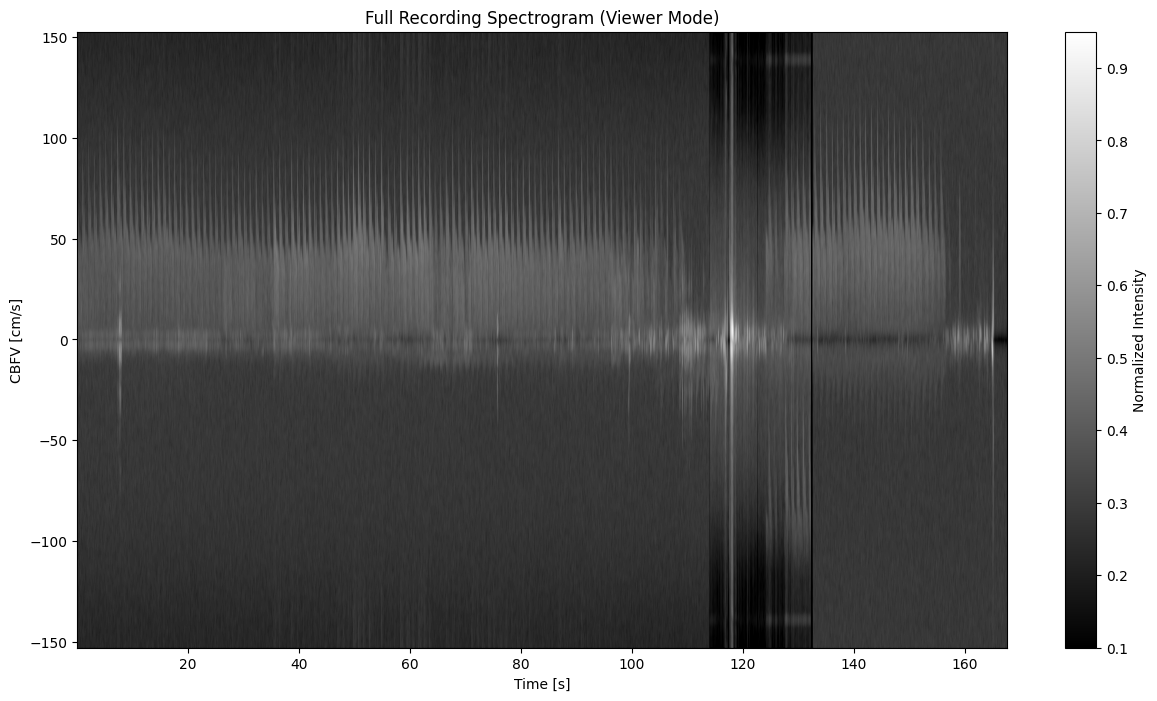

In [7]:
print("Processing full recording for visualization...")

# Parameters
ts_echo_target = 1.4400e-04 # Target sampling period
fs_echo_target = 1.0 / ts_echo_target

# 1. Get raw data arrays
t_raw_viz = preprocess_time_vector(raw_echo_data['t'].values)
I_raw_viz = raw_echo_data['I'].values
Q_raw_viz = raw_echo_data['Q'].values

# 2. Resample Signal (Entire recording) using Pchip
# Ensure unique time points for interpolation
t_unique, unique_indices = np.unique(t_raw_viz, return_index=True)
I_unique = I_raw_viz[unique_indices]
Q_unique = Q_raw_viz[unique_indices]

t_uniform_viz = np.arange(t_unique[0], t_unique[-1], ts_echo_target)
interp_I = PchipInterpolator(t_unique, I_unique)(t_uniform_viz)
interp_Q = PchipInterpolator(t_unique, Q_unique)(t_uniform_viz)
IQ_full = interp_I + 1j * interp_Q

# 3. Generate Spectrogram
f_sp_viz, t_sp_viz, SP_viz, fs_sp_viz = generate_spectrogram(IQ_full, fs_echo_target, t_uniform_viz)

# 4. Convert to Velocity
v_spectrogram_viz = 100 * f_sp_viz * ss / (2 * fc * np.cos(np.deg2rad(angle)))

# 5. Process Image
SP_viz = np.log2(SP_viz + 1e-9)
SP_viz = SP_viz / np.max(SP_viz)
SP_viz = signal.medfilt2d(SP_viz, kernel_size=size_sp_filt)

# 6. Plot Full Spectrogram
plt.figure(figsize=(15, 8))
extent_viz = [t_sp_viz[0], t_sp_viz[-1], v_spectrogram_viz[0], v_spectrogram_viz[-1]]

plt.imshow(SP_viz, aspect='auto', origin='lower', extent=extent_viz, cmap='gray', vmin=0.1, vmax=0.95)
plt.xlabel('Time [s]')
plt.ylabel('CBFV [cm/s]')
plt.title('Full Recording Spectrogram (Viewer Mode)')
plt.colorbar(label='Normalized Intensity')
plt.show()

In [ ]:
# --- Demonstrate CBFV windowing ---
print("\n--- Segmenting processed CBFV into 1024-sample windows ---")
# Use cbfv_adaptive_smooth from the single segment processing (Section 3)
cbfv_windows_example = segment_cbfv_into_windows(cbfv_adaptive_smooth, window_length=1024, overlap=0)
print(f"Created {len(cbfv_windows_example)} CBFV windows of length 1024 from the single segment.")
